In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

# from torchvision import transforms
# from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from tqdm   import tqdm_notebook as tqdm

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [3]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=10):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [4]:
vae = torch.load('b_vae_model', map_location='cpu')
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (

In [5]:
class FITS_100(data.Dataset):
    def __init__(self, images, transform=None):
        self.data = images
        self.data_len = len(self.data)
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
                transforms.CenterCrop(80),
                transforms.Resize(64),
                transforms.ToTensor()])
        else : self.transform = transform

            
    def __getitem__(self, index):
        index = index % self.data_len
        np_arr = self.data[index, :]
        ## reshape np_arr to 28x28
        np_arr = np_arr.reshape(128, 128)

        ## convert to PIL-image
        img = Image.fromarray((np_arr*255).astype('uint8'))

        #apply the transformations and return tensors
        return self.transform(img)
    def __len__(self):
        return self.data_len * 10
    def __repr__(self) -> str:
        return 'unLRG dataset'

In [6]:
directory = '101nvss_fit'
ext = 'fit'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=64)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))


Number of images 101


In [7]:
images = torch.Tensor(images)

In [8]:
with torch.no_grad():
    out, mu, sig = vae(images)

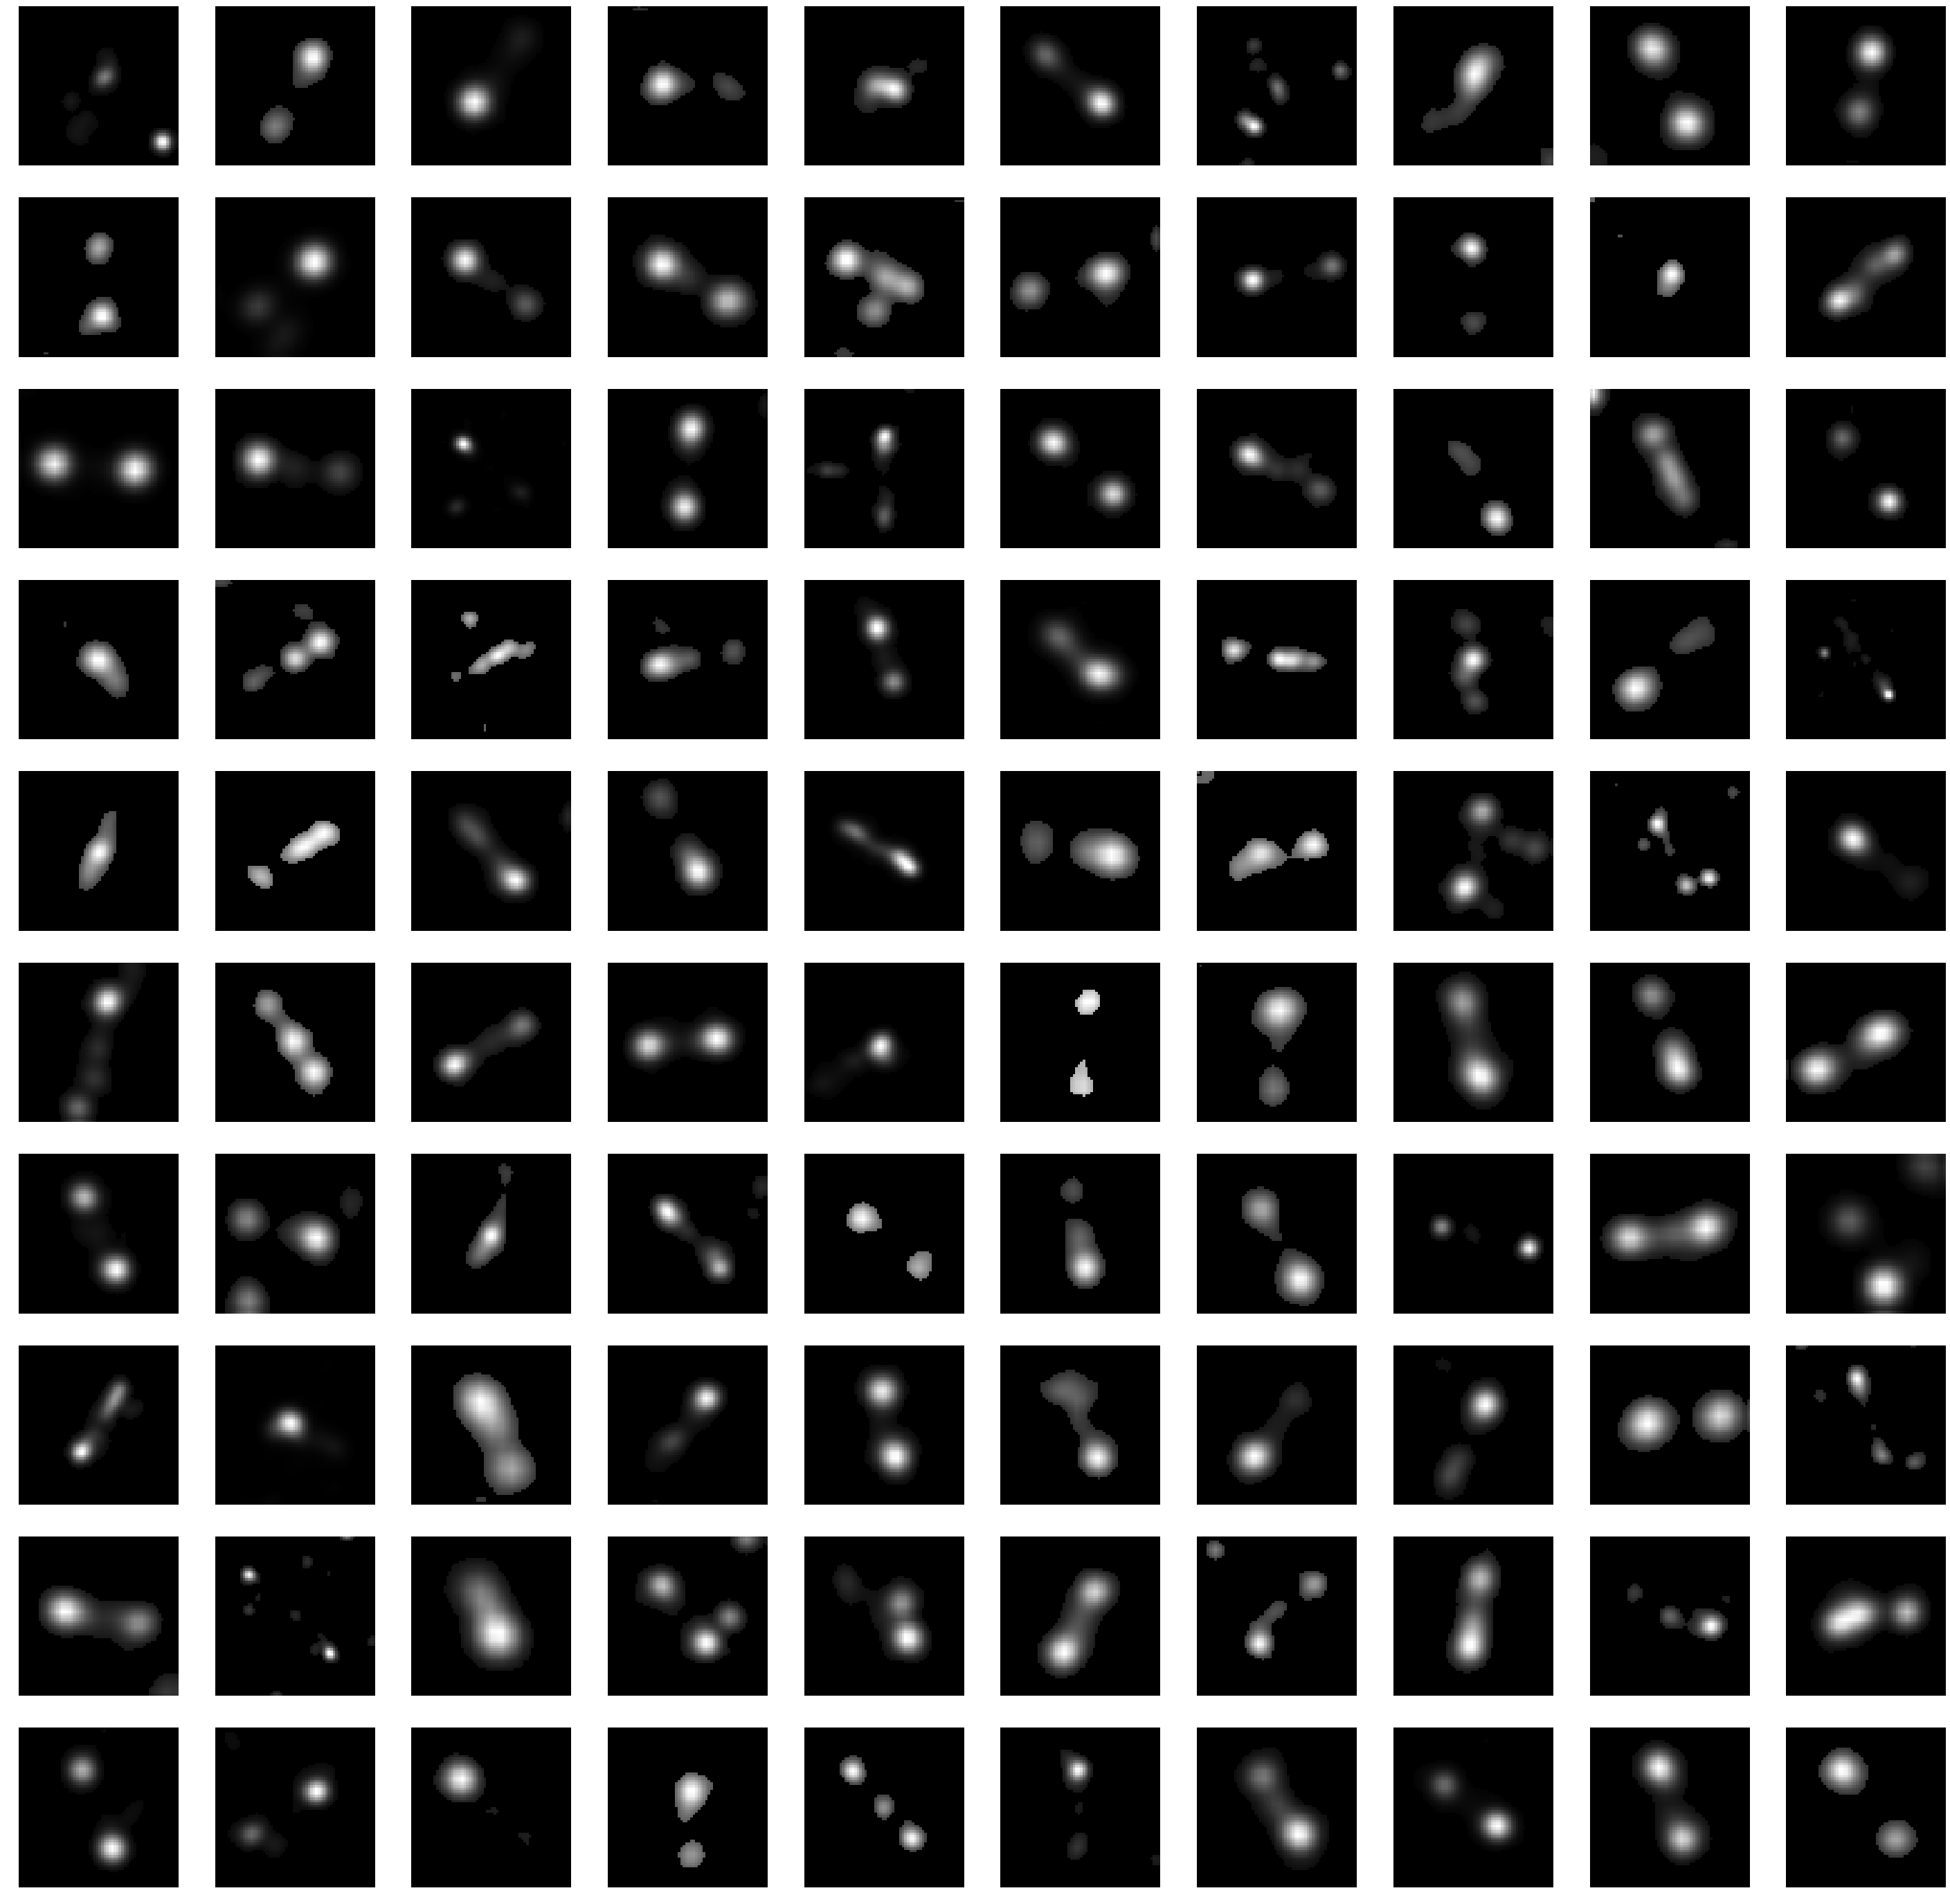

In [9]:
r = 10
nimg = r * 10
k=4
m=1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
#         d = out[i*r + j][0]
        d = images[i*r + j][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')

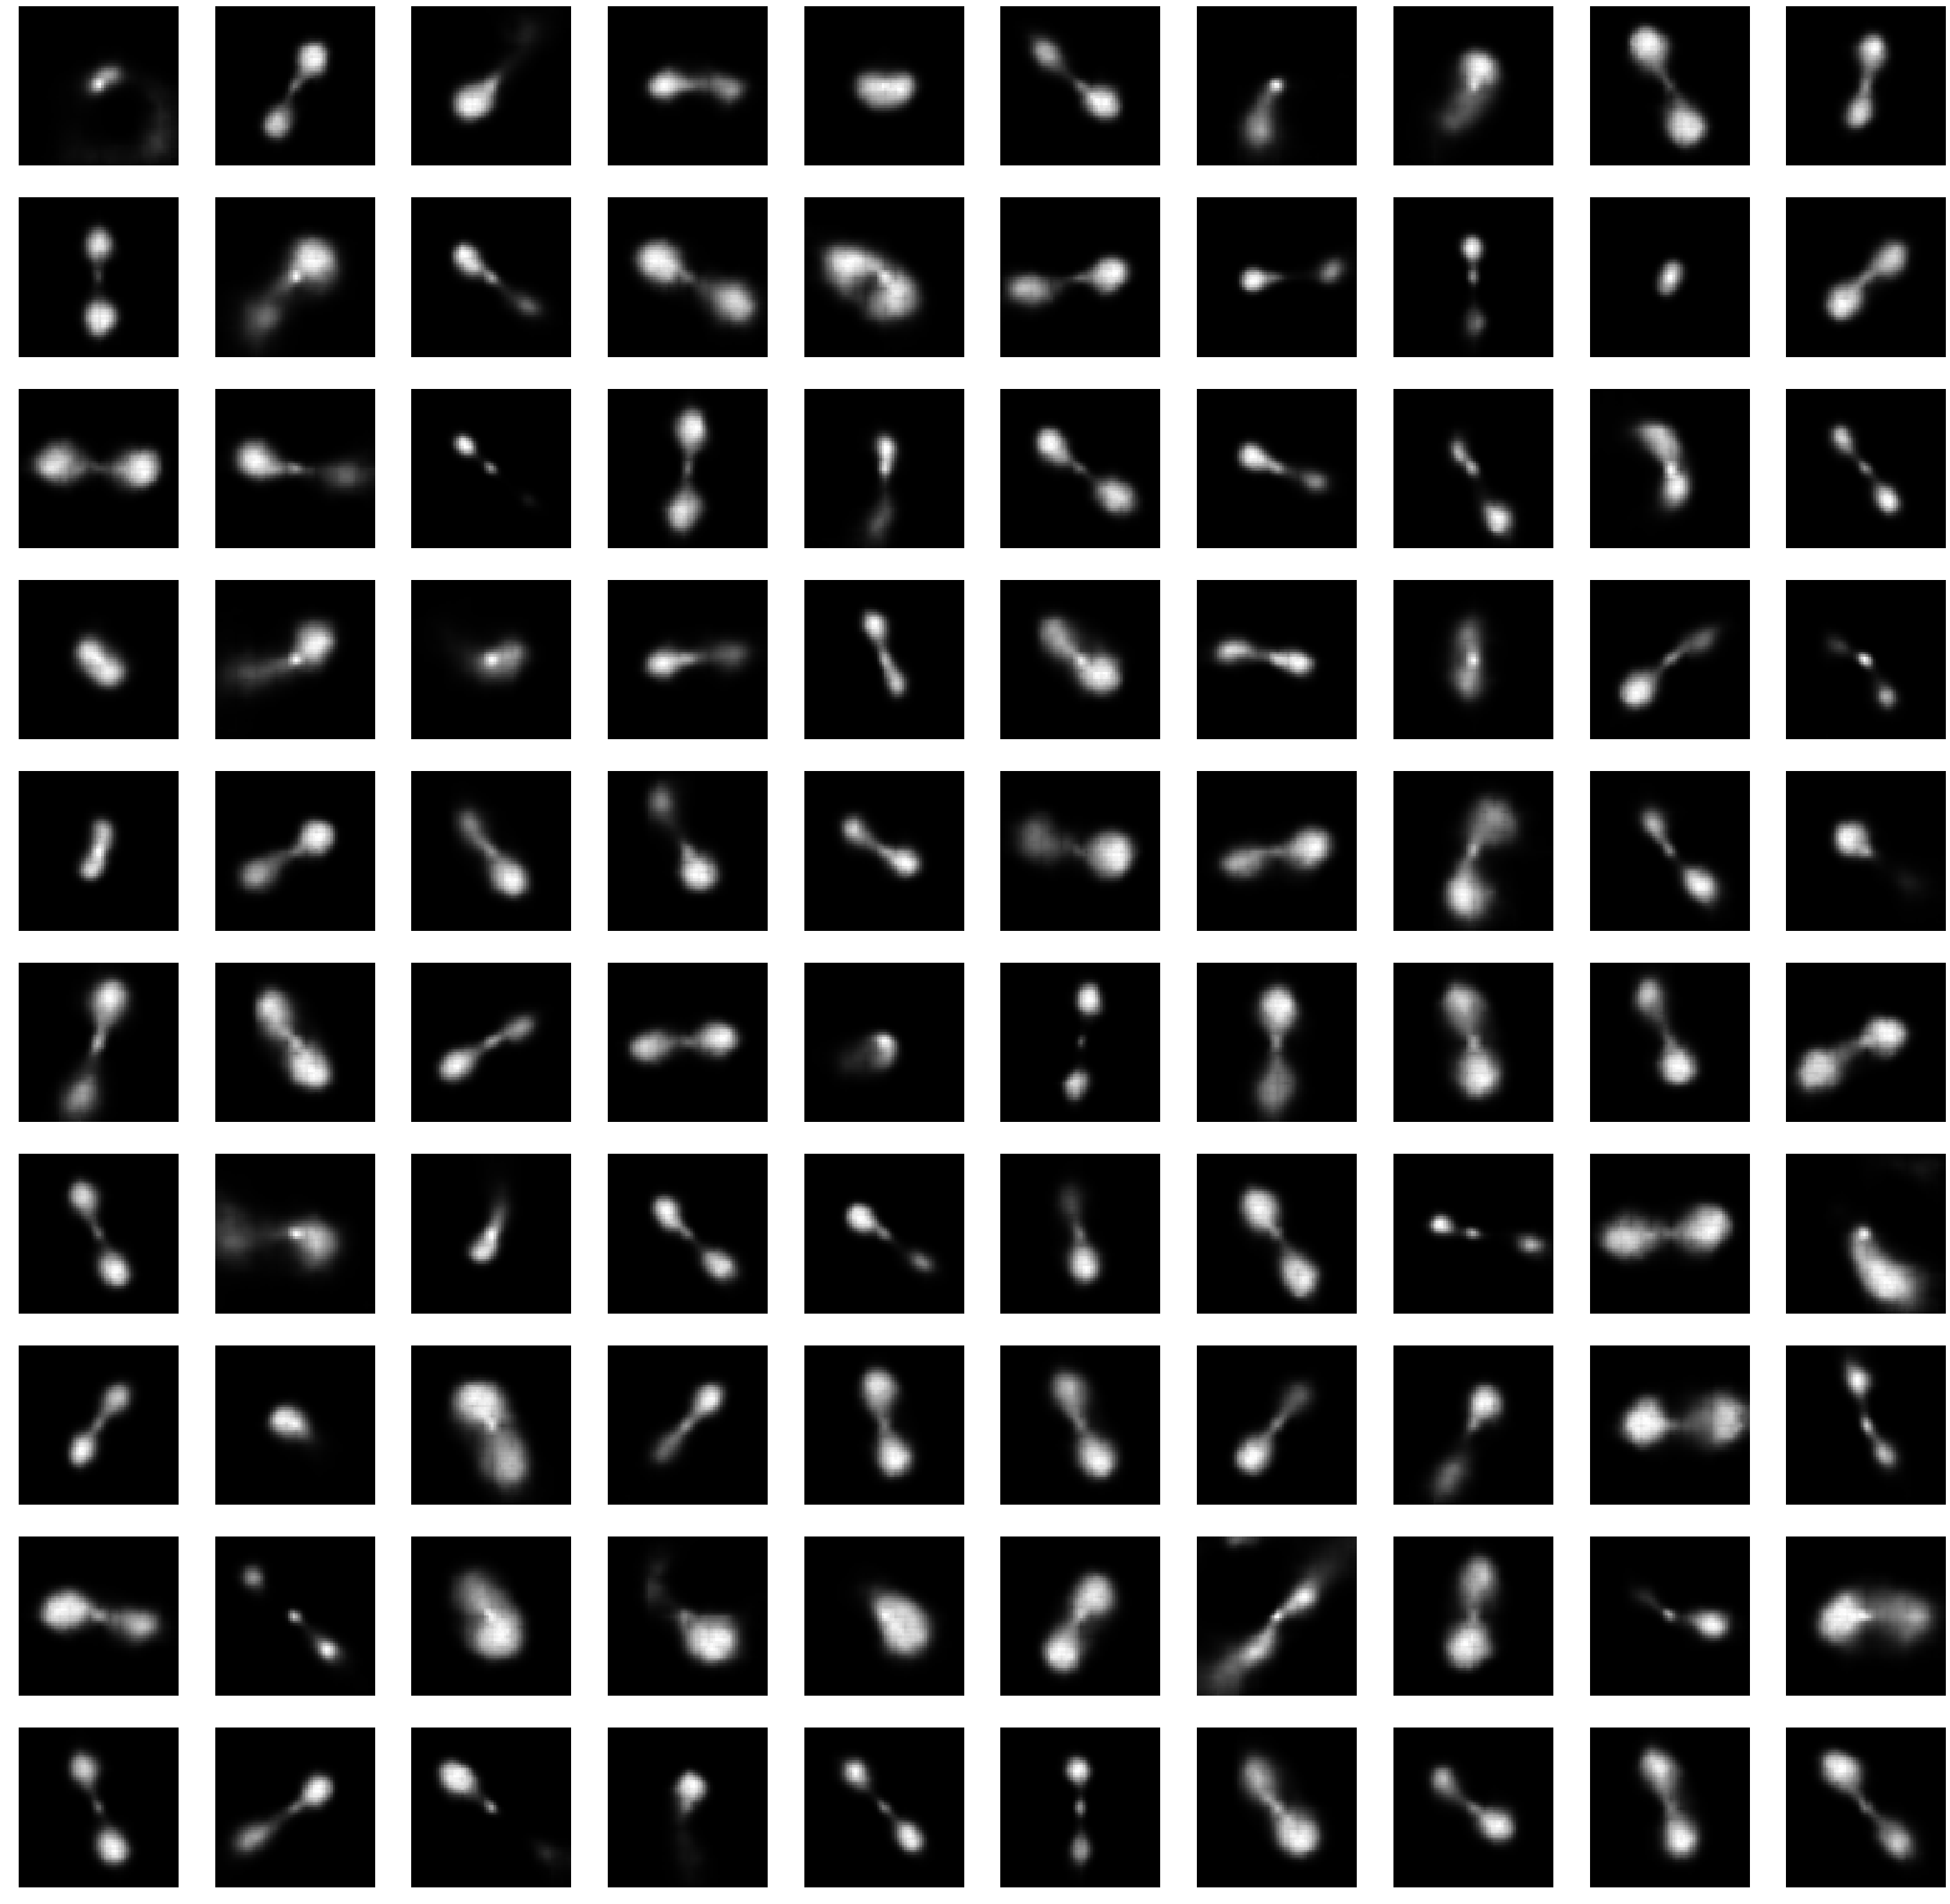

In [10]:
r = 10
nimg = r * 10
k=4
m=1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        d = out[i*r + j][0]
#         d = images[i*r + j][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')

In [11]:
from sklearn import manifold

In [12]:
n_neighbors, n_components = 10, 2
X = mu.numpy()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)

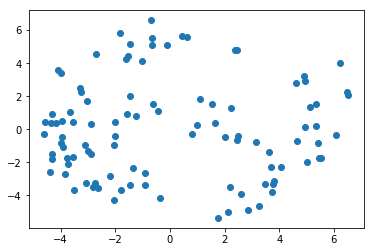

In [13]:
plt.scatter(Y[:,0], Y[:,1])
plt.show()

In [17]:
from matplotlib import offsetbox
from skimage.transform import rescale
def plot_embedding(X, Y, title=None, sz=100):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(100,50))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1])

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(Y.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
# #                 don't show points that are too close
#                 continue
            shown_images = np.r_[shown_images, [X[i]]]
            img = rescale(Y[i], (sz/Y[i].shape[0], sz/Y[i].shape[1]), mode='reflect', multichannel=False, anti_aliasing=False)
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img, cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

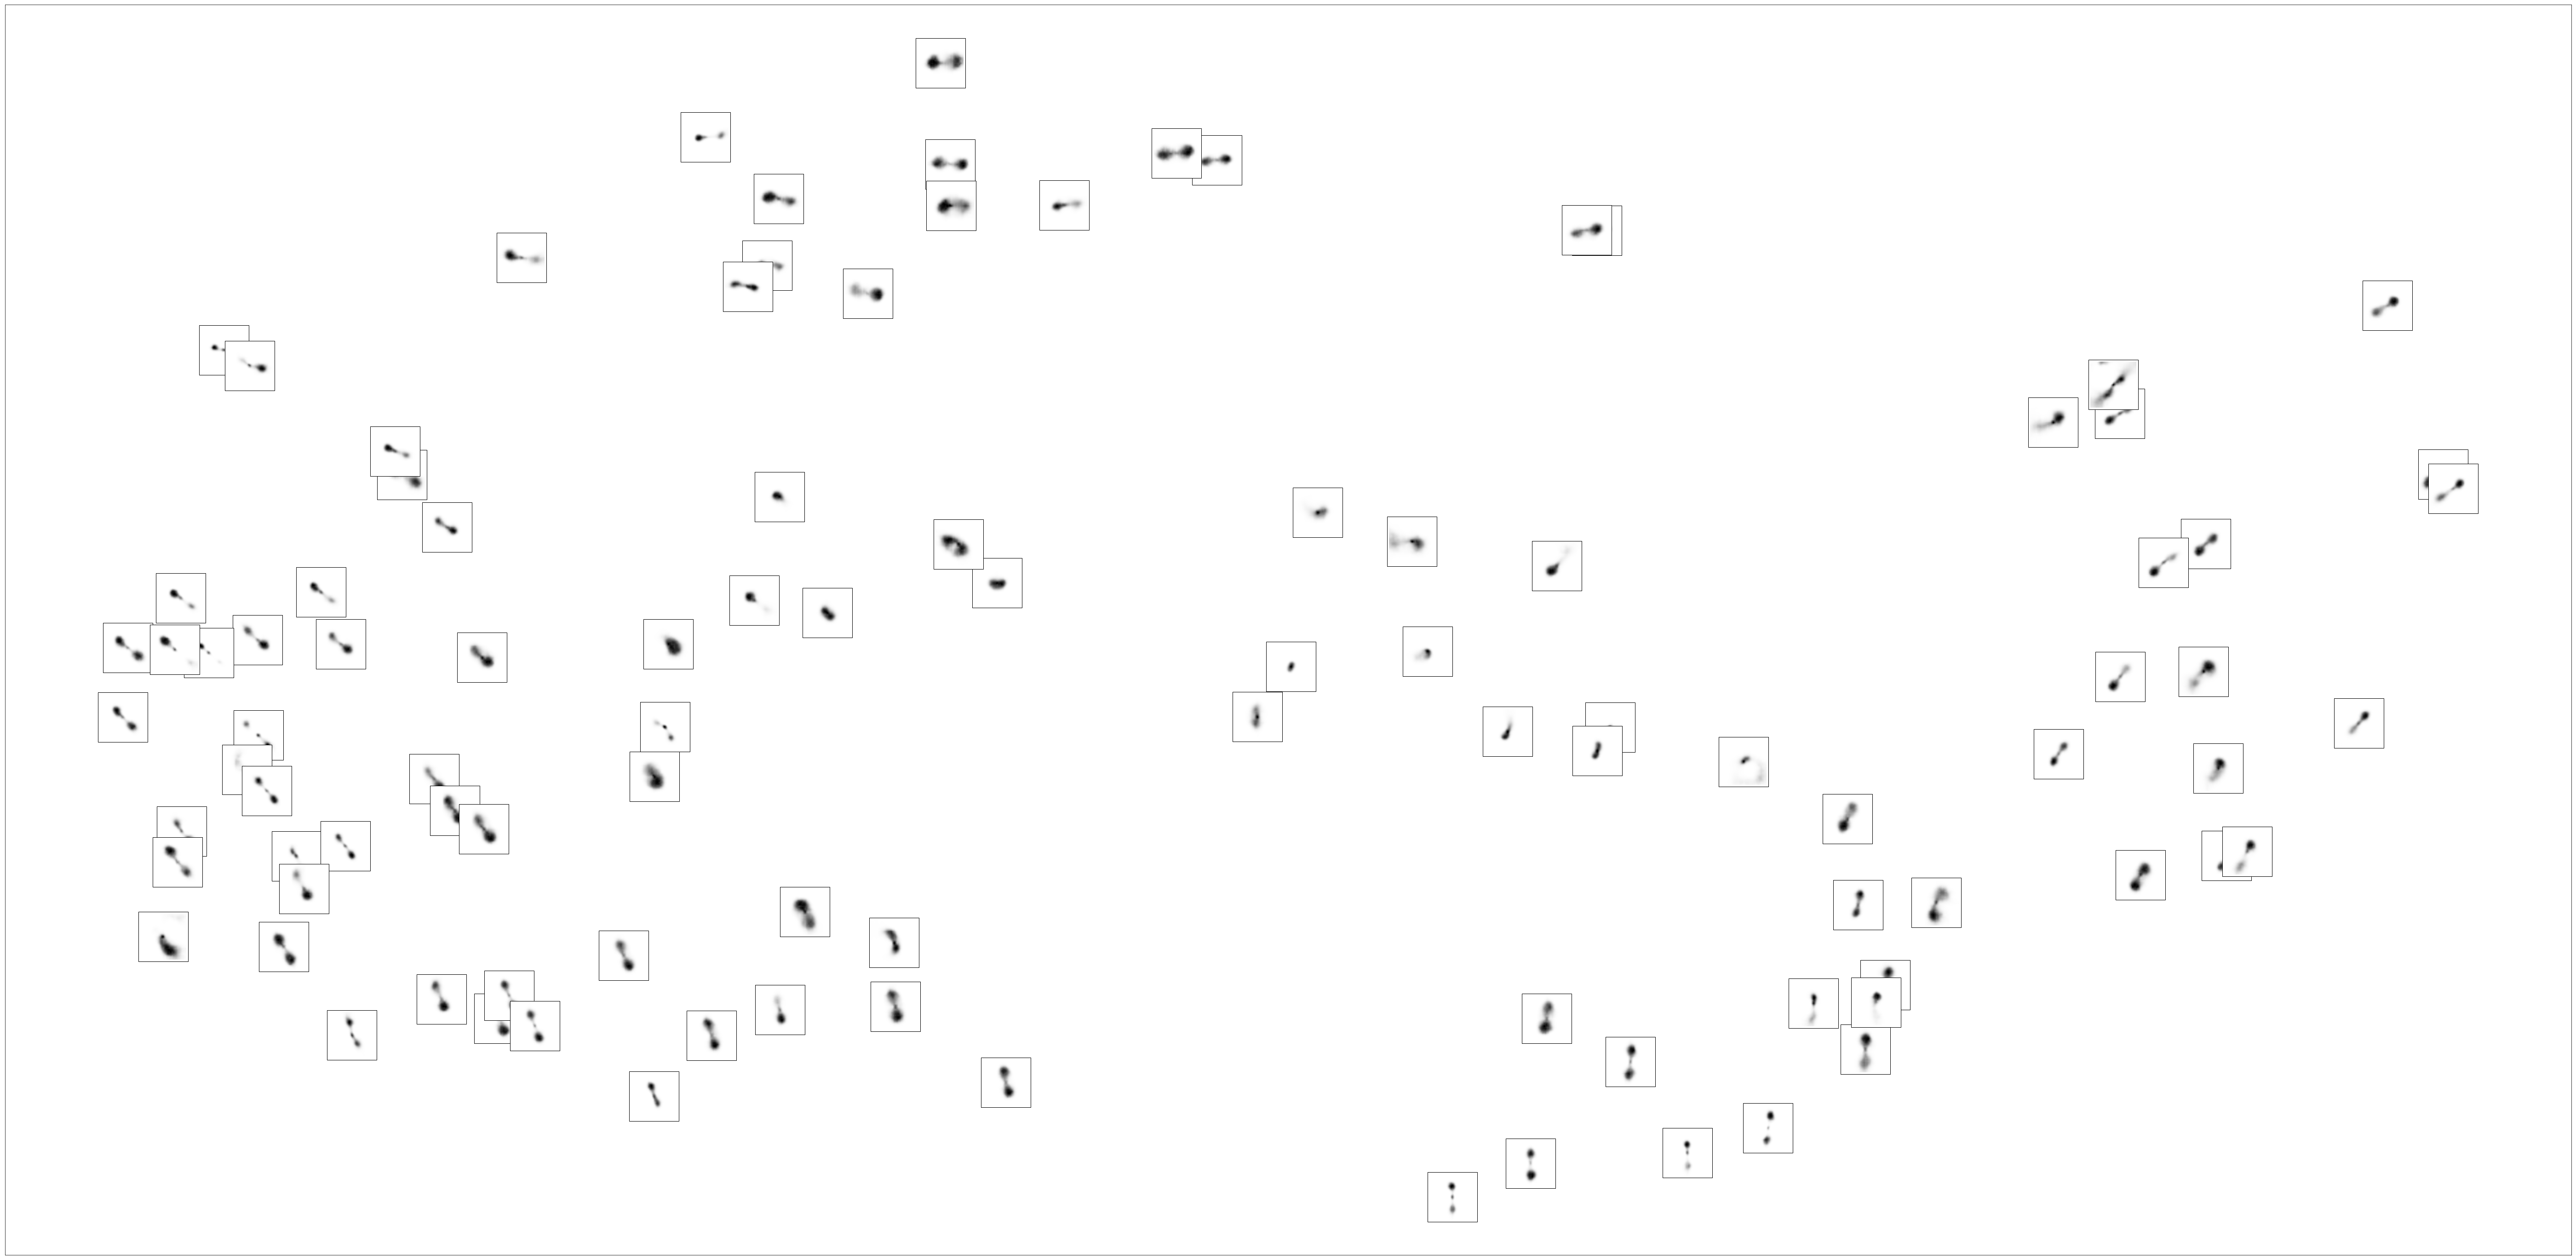

In [20]:
%matplotlib inline
plot_embedding(Y, out.numpy()[:,0])

In [19]:
plt.savefig('101_FIRST_ISOMAP_300', dpi=300, quality=100)

<Figure size 432x288 with 0 Axes>